Say we want to evalute the impact of taking a class online on student performance. We can't simply offer two versions of a class, one online and one in-person, and then compare the performance of the two groups of students. This is because the students who choose to take the online class may be different from those who choose to take the in-person class. For example, students who take the online class may be more motivated and self-directed. To account for this, we can randomize students into the two groups. This is called a randomized controlled trial, or RCT for short.
```

Alpert et al, 2016 conduct exactly this analysis. Let's first clean their raw data:

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings
from IPython.display import set_matplotlib_formats

import statsmodels.api as sm
from linearmodels.panel import PooledOLS
from statsmodels.formula.api import ols

#import norm
import scipy.stats as stats
from scipy.stats import norm

#import statsmodels compare


%matplotlib inline
set_matplotlib_formats('retina')

/var/folders/7v/6lrll0c16r142j8200yccjz00000gn/T/ipykernel_53672/4066883736.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [171]:
df = wage_panel.load()
df = df.rename(
    columns={
        "nr": "id",
        "exper": "experience",
        "expersq": "experience_squared",
        "married": "is_married",
        "union": "is_union_member",
        "lwage": "log_wage",
    }
)
df = df.set_index(["id", "year"])
formula_no_fe = (
    "log_wage ~ 1 + experience + experience_squared + is_married + is_union_member"
)
formula = formula_no_fe + " + EntityEffects"
model_no_fe = PanelOLS.from_formula(formula_no_fe, data=df).fit()
model_no_cluster = PanelOLS.from_formula(formula, data=df).fit()
model = PanelOLS.from_formula(formula, data=df).fit(
    cov_type="clustered", cluster_entity=True
)
results = compare(
    {
        "Pooled OLS": model_no_fe,
        "Fixed Effects without Clustering": model_no_cluster,
        "Fixed Effects": model,
    },
    precision="std_errors",
    stars=True,
).summary

# results to df
df_results = pd.DataFrame(results.tables[0].data)

/Users/calamos/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  vals = concat(


In [172]:
df_results.columns = df_results.iloc[0]
df_results = df_results[1:]
df_results = df_results.iloc[11:21]

In [173]:
df_results

,,Pooled OLS,Fixed Effects without Clustering,Fixed Effects
12,Intercept,1.1177***,1.0649***,1.0649***
13,,(0.0350),(0.0267),(0.0366)
14,experience,0.1140***,0.1168***,0.1168***
15,,(0.0106),(0.0084),(0.0107)
16,experience_squared,-0.0064***,-0.0043***,-0.0043***
17,,(0.0007),(0.0006),(0.0007)
18,is_married,0.1585***,0.0453**,0.0453**
19,,(0.0163),(0.0183),(0.0210)
20,is_union_member,0.1612***,0.0821***,0.0821***
21,,(0.0179),(0.0193),(0.0228)


In [153]:
df_results[
    df_results["0"].isin(
        ["", "experience", "experience_squared", "is_married", "is_union_member"]
    )
]

KeyError: '0'

In [130]:
model

Dep. Variable:,log_wage,R-squared:,0.1780
Estimator:,PanelOLS,R-squared (Between):,-0.0482
No. Observations:,4360,R-squared (Within):,0.1780
Date:,"Mon, Nov 06 2023",R-squared (Overall):,0.0565
Time:,12:40:21,Log-likelihood,-1331.6
Cov. Estimator:,Clustered,,
,,F-statistic:,206.38
Entities:,545,P-value,0.0000
Avg Obs:,8.0000,Distribution:,"F(4,3811)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,108.12


In [124]:
df = wage_panel.load()
df = df.rename(
    columns={
        "nr": "i",
        "year": "t",
        "exper": "experience",
        "expersq": "experience_squared",
        "married": "is_married",
        "union": "is_union_member",
        "lwage": "log_wage",
    }
)[
    [
        "i",
        "t",
        "experience",
        "experience_squared",
        "is_married",
        "is_union_member",
        "log_wage",
    ]
]

# Demean the data
for col in [
    "experience",
    "experience_squared",
    "is_married",
    "is_union_member",
    "log_wage",
]:
    df[col + "_demeaned"] = df.groupby("i")[col].transform(lambda x: x - x.mean())

In [122]:
# Estimate the model using OLS
endog = df["log_wage_demeaned"]
exog = df[
    [
        "experience_demeaned",
        "experience_squared_demeaned",
        "is_married_demeaned",
        "is_union_member_demeaned",
    ]
]
sm.OLS(endog, exog).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
experience_demeaned,0.1168,0.008,14.837,0.000,0.101,0.132
experience_squared_demeaned,-0.0043,0.001,-7.597,0.000,-0.005,-0.003
is_married_demeaned,0.0453,0.017,2.645,0.008,0.012,0.079
is_union_member_demeaned,0.0821,0.018,4.549,0.000,0.047,0.117


In [128]:
X = exog
y = endog
model = sm.OLS(endog, exog).fit()
y_hat = model.predict(X)
epsilon = y - y_hat

# Compute cluster-robust standard errors
bread = np.linalg.inv(X.T @ X)
# Instead of summing over each individual, we first sum over the groups.
meat = []
for i in range(len(clusters)):
    cluster = 


standard_errors = np.sqrt(np.diag(sandwhich))
t_stats = model.params / standard_errors
p_values = norm.sf(abs(t_stats)) * 2
results = pd.DataFrame(
    {
        "Coefficient": model.params,
        "Standard Error": standard_errors,
        "t-stat": t_stats,
        "p-value": p_values,
    }
)
results

,Coefficient,Standard Error,t-stat,p-value
experience_demeaned,0.116847,0.008542,13.679624,1.343866e-42
experience_squared_demeaned,-0.004301,0.000560,-7.681742,1.569401e-14
is_married_demeaned,0.045303,0.016946,2.673336,7.510108e-03
is_union_member_demeaned,0.082087,0.018227,4.503614,6.680739e-06


In [10]:
from linearmodels.datasets import wage_panel

df = wage_panel.load()

<AxesSubplot:ylabel='Frequency'>

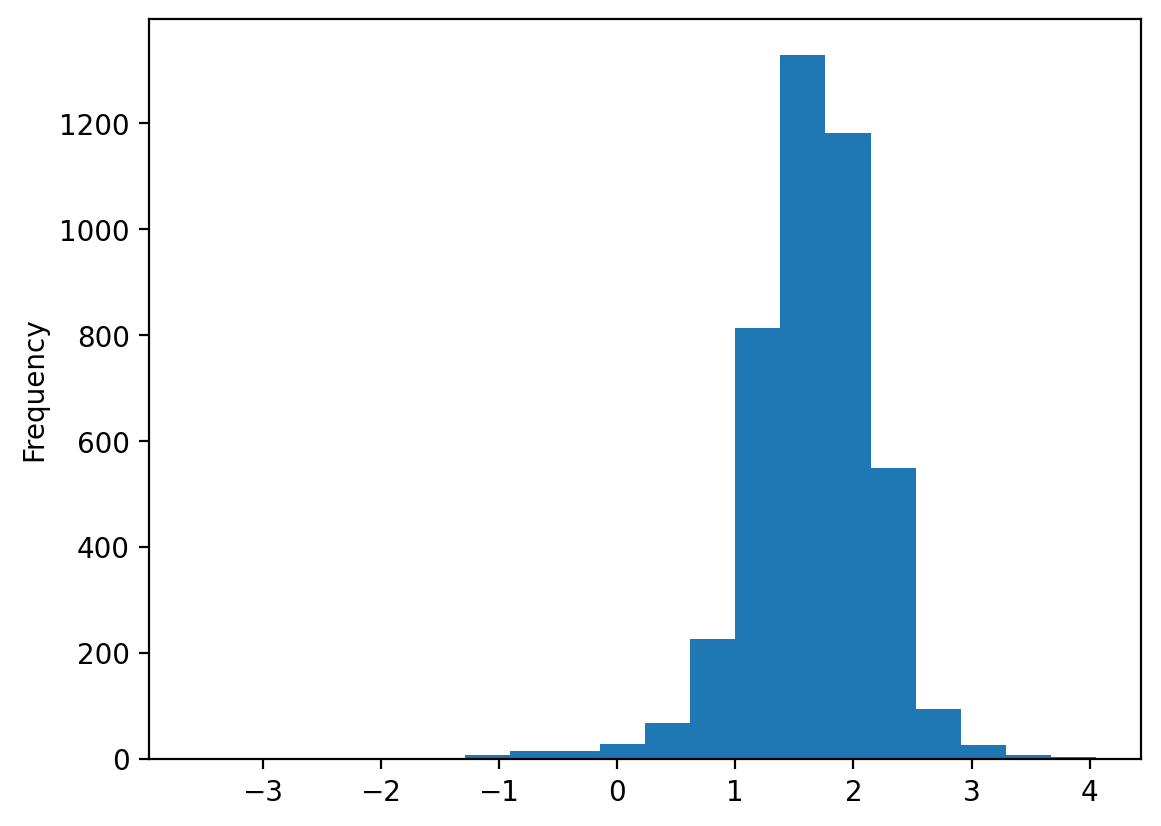

In [26]:
df["log_wage"].plot.hist(bins=20)

In [43]:
# see variaqble types and missing values for df
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4360 entries, (13, 1980) to (12548, 1987)
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   log_wage  4360 non-null   float64
 1   married   4360 non-null   int64  
 2   black     4360 non-null   int64  
 3   hispanic  4360 non-null   int64  
 4   exper     4360 non-null   int64  
 5   educ      4360 non-null   int64  
 6   hours     4360 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 272.1 KB


In [56]:
data.columns

Index(['nr', 'year', 'black', 'exper', 'hisp', 'hours', 'married', 'educ',
       'union', 'lwage', 'expersq', 'occupation'],
      dtype='object')

<AxesSubplot:xlabel='educ', ylabel='log_wage'>

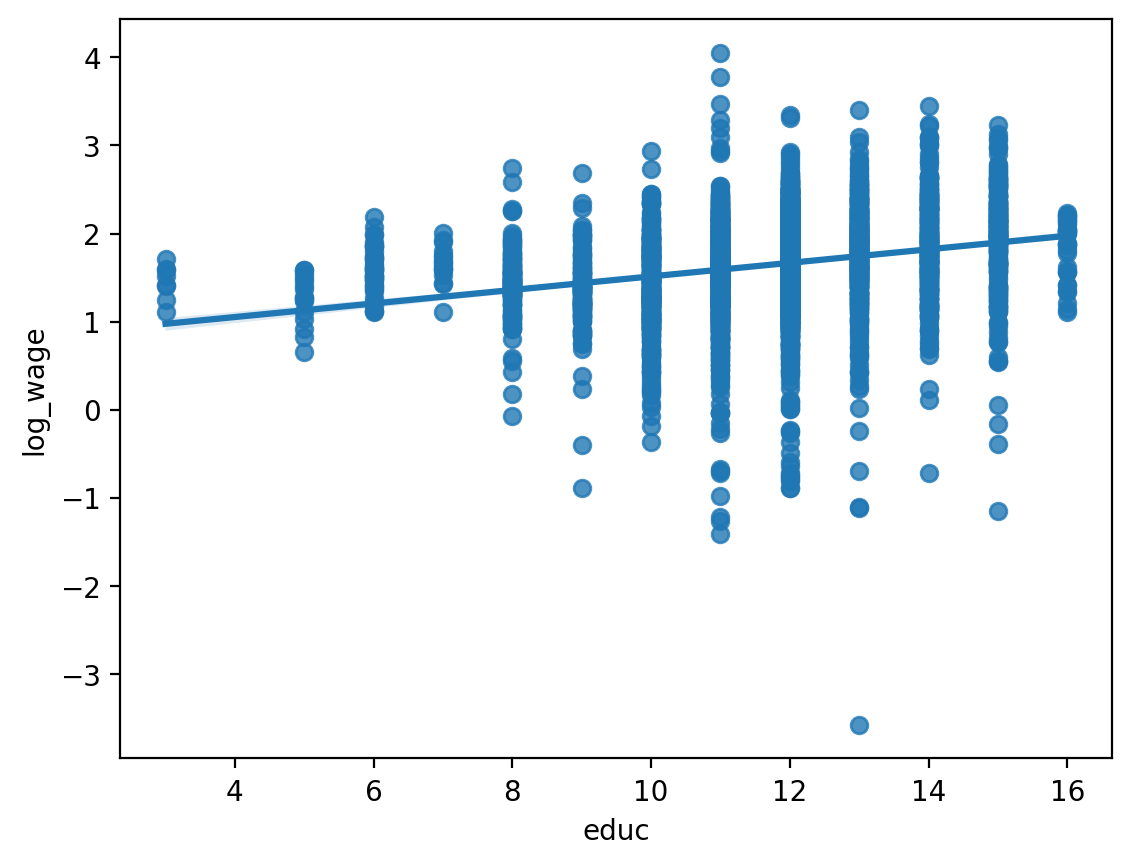

In [66]:
# plot educ and lwage 1 regression line
sns.regplot(x="educ", y="log_wage", data=df)

In [74]:
from linearmodels import PanelOLS
from linearmodels.datasets import wage_panel

data = wage_panel.load()
mod = PanelOLS.from_formula("lwage ~ exper+EntityEffects", data=data.set_index(["nr"]))

result = mod.fit(cov_type="clustered", cluster_entity=True)
result.summary.tables[1]

PatsyError: Error evaluating factor: NameError: name 'lwage' is not defined
    0 + lwage
        ^^^^^

In [102]:
from linearmodels import PanelOLS
from linearmodels.datasets import wage_panel
from linearmodels.panel.results import compare

df = wage_panel.load()
df = df.rename(
    columns={
        "nr": "id",
        "exper": "experience",
        "expersq": "experience_squared",
        "married": "is_married",
        "union": "is_union_member",
        "lwage": "log_wage",
    }
)
df = df.set_index(["id", "year"])
formula_no_fe = (
    "log_wage ~ experience + experience_squared + is_married + is_union_member"
)
formula = formula_no_fe + " + EntityEffects"
model_no_fe = PanelOLS.from_formula(formula_no_fe, data=df).fit(
    cov_type="clustered", cluster_entity=True
)
model = PanelOLS.from_formula(formula, data=df).fit(
    cov_type="clustered", cluster_entity=True
)
compare({"Pooled OLS": model_no_fe, "Fixed Effects": model})

/Users/calamos/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  vals = concat(
/Users/calamos/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  vals = concat(


,Pooled OLS,Fixed Effects
Dep. Variable,log_wage,log_wage
Estimator,PanelOLS,PanelOLS
No. Observations,4360,4360
Cov. Est.,Clustered,Clustered
R-squared,0.8942,0.1780
R-Squared (Within),-0.1714,0.1780
R-Squared (Between),0.9429,0.5496
R-Squared (Overall),0.8942,0.5333
F-statistic,9205.5,206.38
P-value (F-stat),0.0000,0.0000


In [ ]:
df

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4355,12548,1983,0,8,0,2080,1,9,0,1.591879,64,5
4356,12548,1984,0,9,0,2080,1,9,1,1.212543,81,5
4357,12548,1985,0,10,0,2080,1,9,0,1.765962,100,5
4358,12548,1986,0,11,0,2080,1,9,1,1.745894,121,5


In [65]:
yr1980["wage"] = yr1980["lwage"].apply(lambda x: np.exp(x))

/var/folders/7v/6lrll0c16r142j8200yccjz00000gn/T/ipykernel_35747/1161372340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yr1980["wage"] = yr1980["lwage"].apply(lambda x: np.exp(x))


In [70]:
# yr1980 = yr1980[["wage", "hours", "educ"]]
yr1980.columns = ["Hourly Wage (USD)", "hours_worked", "Years of Schooling"]

In [71]:
yr1980

,Hourly Wage (USD),hours_worked,Years of Schooling
0,3.311959,2672,14
8,5.343934,2484,13
16,4.553804,2332,12
24,6.646664,1864,12
32,7.020083,2080,12
...,...,...,...
4320,2.905159,1584,14
4328,9.147375,2080,12
4336,2.644290,2008,12
4344,6.296803,2080,11


In [76]:
yr1980["Hourly Wage (USD)"] *= 3.68

/var/folders/7v/6lrll0c16r142j8200yccjz00000gn/T/ipykernel_35747/1593836699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yr1980["Hourly Wage (USD)"] *= 3.68


In [77]:
yr1980[["Hourly Wage (USD)", "Years of Schooling"]].to_csv(
    "data/wage_education.csv", index=False
)

In [82]:
df

,Hourly Wage (USD),Years of Schooling
0,12.188011,14
1,19.665675,13
2,16.758000,12
3,24.459722,12
4,25.833904,12
...,...,...
540,10.690984,14
541,33.662342,12
542,9.730987,12
543,23.172234,11


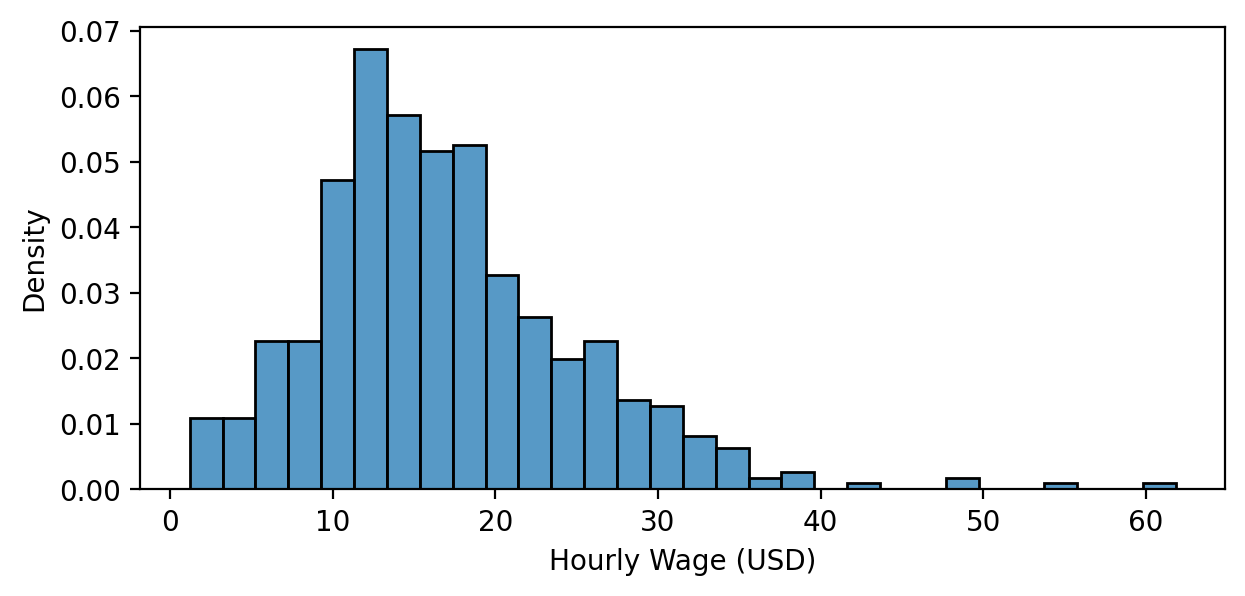

In [79]:
df = pd.read_csv("data/wage_education.csv")
fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(
    data=df,
    x="Hourly Wage (USD)",
    stat="density",
    bins=30,
    ax=ax,
)
plt.show()

In [85]:
df = pd.read_csv("data/wage_education.csv")
endog = np.log(df["Hourly Wage (USD)"])
exog = sm.add_constant(df["Years of Schooling"])
model = sm.OLS(endog, exog)
results = model.fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,2.0164,0.160,12.590,0.000,1.702,2.331
Years of Schooling,0.0578,0.013,4.292,0.000,0.031,0.084


In [6]:
df = pd.read_csv("data/marriage_panel.csv")

In [9]:
df.tail()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
930,520,40,2.564949,79,16,6,1,30,1,1,1,0,0,1.0,11.0,NaN
931,1202,40,3.402863,102,13,10,3,31,1,0,1,1,7,7.0,8.0,6.0
932,538,45,2.481196,77,12,12,10,28,1,1,1,0,9,NaN,7.0,NaN
933,873,44,2.987746,109,12,12,12,28,1,0,1,0,1,1.0,NaN,11.0
934,1000,40,3.218876,107,12,17,18,35,1,0,1,0,5,1.0,NaN,NaN


In [7]:
df.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
1,808,50,2.782539,119,18,11,16,37,1,0,0,1,1,NaN,14.0,14.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0


In [ ]:
# run fixed effects model from formula
mod = PooledOLS.from_formula("logwage ~ 1 + educ + C(year) + EntityEffects", data=df)

In [21]:
mod = PooledOLS.from_formula(
    "lwage ~ 1 + exper + expersq + married + educ + union", data=df
)
res = mod.fit(cov_type="clustered", cluster_entity=True)

In [22]:
res

Dep. Variable:,lwage,R-squared:,0.1790
Estimator:,PooledOLS,R-squared (Between):,0.1890
No. Observations:,4360,R-squared (Within):,0.1674
Date:,"Sun, Oct 29 2023",R-squared (Overall):,0.1790
Time:,15:37:15,Log-likelihood,-3009.5
Cov. Estimator:,Clustered,,
,,F-statistic:,189.86
Entities:,545,P-value,0.0000
Avg Obs:,8.0000,Distribution:,"F(5,4354)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,75.298


In [23]:
# get column labels from stata file
from pandas.io.stata import StataReader

reader = StataReader("data/bertrand_audit_data.dta")
df = reader.read(convert_categoricals=False)
labels = reader.variable_labels()
labels

{'id': 'ID',
 'ad': 'Ad #',
 'education': '0=not reported; 1=HSD; 2=HSG; 3=some col; 4=col +',
 'ofjobs': 'number of jobs listed on resume',
 'yearsexp': 'number of years of work experience on the resume',
 'honors': '1=resume mentions some honors',
 'volunteer': '1=resume mentions some volunteering experience',
 'military': '1=applicant has some military experience',
 'empholes': '1=resume has some employment holes',
 'occupspecific': 'Occup. Specific',
 'occupbroad': 'Occup. Broad',
 'workinschool': '1=resume mentions some work experience while at school',
 'email': "1=email address on applicant's resume",
 'computerskills': '1=resume mentions some computer skills',
 'specialskills': '1=resume mentions some special skills',
 'firstname': "applicant's first name",
 'sex': '',
 'race': '',
 'h': '1=high quality resume',
 'l': '1=low quality resume',
 'call': '1=applicant was called back',
 'city': 'c=chicago; b=boston',
 'kind': '',
 'adid': 'employment ad identifier',
 'fracblack': "f

In [24]:
df = pd.read_stata("data/bertrand_audit_data.dta")
df = df[["call", "race", "yearsexp", "h"]]
df = df.rename(
    columns={
        "call": "CallBack",
        "race": "BlackName",
        "yearsexp": "Experience",
        "h": "HighQuality",
    }
)
df["BlackName"] = (df["BlackName"] == "b").astype(int)

In [25]:
# import norm
from scipy.stats import norm

# Define X and y
X = df[["BlackName", "Experience"]].to_numpy()
X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add intercept
y = df["CallBack"].to_numpy()
# Compute beta hat
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
# Compute standard error of beta hat
se_beta_hat = np.sqrt(
    np.diag(
        np.linalg.inv(X.T @ X)
        * ((y - X @ beta_hat).T @ (y - X @ beta_hat))
        / (X.shape[0] - X.shape[1])
    )
)
# Compute t-statistic
t_stat = beta_hat / se_beta_hat
# Compute p-value
p_val = 2 * (1 - norm.cdf(abs(t_stat)))
# Display results
results = pd.DataFrame(
    {
        "Coefficient": beta_hat,
        "Standard Error": se_beta_hat,
        "p-value": p_val,
    },
    index=["Intercept", "BlackName", "Experience"],
)

In [26]:
results

,Coefficient,Standard Error,p-value
Intercept,0.070543,0.008174,0.000000
BlackName,-0.031945,0.007771,0.000039
Experience,0.003305,0.000770,0.000018


In [27]:
# check with statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

# run regression
model = ols("CallBack ~ BlackName + Experience", data=df).fit()
# display results with 7 significant digits
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CallBack   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     17.70
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           2.19e-08
Time:                        15:37:16   Log-Likelihood:                -553.05
No. Observations:                4870   AIC:                             1112.
Df Residuals:                    4867   BIC:                             1132.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0705      0.008      8.630      0.000       0.055       0.087
BlackName     -0.0319      0.008     -4.111      0.000      -0.047      -0.017
Experience     0.0033      0.001      4.291      0.000       0.002       0.005
==============================================================================
Omnibus:                     2953.901   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18682.700
Skew:                           3.051   Prob(JB):                         0.00
Kurtosis:                      10.406   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
import statsmodels.api as sm

model = sm.formula.ols(
    formula="CallBack ~ BlackName + Experience + BlackName * Experience",
    data=df,
).fit()
# turn table to panadas dataframe
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0693,0.010,6.842,0.000,0.049,0.089
BlackName,-0.0294,0.014,-2.043,0.041,-0.058,-0.001
Experience,0.0035,0.001,3.205,0.001,0.001,0.006
BlackName:Experience,-0.0003,0.002,-0.214,0.830,-0.003,0.003


In [29]:
# run probit model
from statsmodels.formula.api import probit
from statsmodels.formula.api import logit

probit_model = logit(
    formula="CallBack ~ BlackName + Experience + HighQuality + BlackName * Experience + BlackName * HighQuality",
    data=df,
).fit()

probit_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.276198
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-2.6374,0.143,-18.431,0.000,-2.918,-2.357
BlackName,-0.4239,0.221,-1.921,0.055,-0.856,0.009
Experience,0.0337,0.012,2.756,0.006,0.010,0.058
HighQuality,0.2322,0.139,1.671,0.095,-0.040,0.505
BlackName:Experience,0.0100,0.019,0.533,0.594,-0.027,0.047
BlackName:HighQuality,-0.1898,0.217,-0.876,0.381,-0.614,0.235


In [40]:
# include quadratic experience term
model = sm.formula.ols(
    formula="CallBack ~  Experience + np.power(Experience, 2)",
    data=df,
).fit()
# rename vaiable names

AttributeError: 'SimpleTable' object has no attribute 'rename'

In [44]:
df.shape

(4870, 5)

In [31]:
# group by quality and race and calculate returns to quality by race
df.groupby(["BlackName", "HighQuality"]).mean()

CallBack  Experience
BlackName HighQuality                      
0         0.0          0.084983    7.394389
          1.0          0.107931    8.313982
1         0.0          0.061881    7.380363
          1.0          0.067048    8.274734

We can plot the distribution of grades for each group:

In [32]:
sns.displot(
    data=df,
    x="Final Exam Score",
    hue="Online Format",
    stat="density",
    bins=30,
    palette="husl",
    height=4,
    aspect=2,
)
plt.axvline(
    x=df[df["Online Format"]]["Final Exam Score"].mean(),
    color=sns.color_palette("husl")[3],
)
plt.axvline(
    x=df[~df["Online Format"]]["Final Exam Score"].mean(),
    color=sns.color_palette("husl")[0],
)
plt.grid(axis="x")
plt.show()

ValueError: Could not interpret value `Final Exam Score` for parameter `x`

Let's compute the numerical values for the means of each group:

In [ ]:
(
    df.groupby("Online Format")
    .mean()
    .reset_index()
    .rename(columns={"Final Exam Score": "Mean Final Exam Score"})
)

,Online Format,Mean Final Exam Score
0,False,78.547485
1,True,73.635262


We can see that students in the online class are faring worse by 78.54 - 73.63 = 4.91 points. But how can we be sure this isn't a statistical fluke?  To answer this, we'll consider the following question: What is the probability that, given in-person and online classes have the same average grade, we would observe a difference in average grade as large as the one we observed in our data? Let's formulate this mathematically.

Let $X$ denote the difference in means between the two groups. We can write this as $X = \bar{X}_1 - \bar{X}_2$ where $\bar{X}_1$ and $\bar{X}_2$ are the sample means of the in-person and online classes respectively. We can then write the probability we're interested in as:
$P(|X| > 4.91).$
We call this the p-value. It is the probability that, given the null hypothesis that the two groups have the same average grade (i.e. $\bar{X}=0$), we would observe a difference in average grade as large as the one we observed in our data. If this probability is small, then we can reject the null hypothesis and conclude that the two groups do not have the same average grade. Usually, the threshold for rejecting the null hypothesis is 0.05 by convention.

Notice that that $P(|X| > 4.91) = P(X> 4.91) + P(X< -4.91) = 2P(X< -4.91) = 2\Phi(\frac{-4.91}{\sigma})$

So we want to check whether $2\Phi(\frac{-4.91}{\sigma}) < 0.05$. But first, we need to calculate $\sigma$.

Recall $X = \bar{X}_1 - \bar{X}_2$, which implies that $Var(X) = Var(\bar{X}_1) + Var(\bar{X}_2)$.

Of course, the mean of a random variable $X$ is just $\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i$.
We can therefore derive its variance as follows:

$\begin{aligned} \operatorname{Var}\left[\bar{X}\right] & =\operatorname{Var}\left[\frac{1}{n} \sum_{i=1}^n X_i\right] \\ & =\frac{1}{n^2} \operatorname{Var}\left[\sum_{i=1}^n X_i\right] \\ & =\frac{1}{n^2} \sum_{i=1}^n \operatorname{Var}\left[X_i\right] \\ & =\frac{1}{n^2} \sum_{i=1}^n \sigma^2 \\ & =\frac{1}{n^2} n \sigma^2=\frac{\sigma^2}{n}\end{aligned}$

Thus, the variance of $X = \bar{X}_1 - \bar{X}_2$ is $\begin{aligned}\frac{\sigma_1^2}{n_1}+\frac{\sigma_2^2}{n_2}\end{aligned}$

Now, let's calculate the p-value:

In [ ]:
online = df[df["Online Format"]]["Final Exam Score"]
in_person = df[~df["Online Format"]]["Final Exam Score"]
sigma1, mu1, n1 = online.std(), online.mean(), online.shape[0]
sigma2, mu2, n2 = in_person.std(), in_person.mean(), in_person.shape[0]

# Calculate the standard deviation of X
sd = np.sqrt(((sigma1**2) / n1) + ((sigma2**2) / n2))
p_val = 2 * norm.cdf(-abs(mu1 - mu2) / sd)
print(f"p-value: {p_val:.4f}")

p-value: 0.0054


We have shown that, if there were no difference between the two groups, the probability of observing a difference at least as large as the one we observed is 0.0054. We can therefore reject the null hypothesis and conclude that the two groups do not have the same average grade.